**Step 1. Get, transform data!!**

In [1]:
## Creation date: May 28, 2023

In [2]:
import pandas as pd
import flair
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

pd.options.mode.chained_assignment = None  # default='warn'

plt.rc('xtick', labelsize=8)
plt.rc('ytick', labelsize=8)

In [3]:
# Run once or skip!
#flair_sentiment = flair.models.TextClassifier.load('en-sentiment')

In [4]:
sns.set_style("whitegrid")
sns.set_context("notebook")

### Read in txt file
---

Transform data. Replace chat.txt with an exported (and renamed) copy of the Whatsapp chat

In [5]:
# bring in data and give it column name 'text'
data = pd.read_table('chat2.txt', names=['text'], header=None)

# Drop the first line which has the boilerplate Whatsapp text
data = data.iloc[2:]

In [6]:
#print(data[0:2].values)
#data.head()

In [7]:
# Extract date and time from messages
data.loc[:, 'date'] = data['text'].str.extract(r'(\d{2}/\d{2}/\d{4})')
data.loc[:, 'time'] = data['text'].str.extract(r'(\d{2}:\d{2})')

In [8]:
# Update text column to now have purely just the text.
data['text'] = data['text'].str.replace(r'\d{2}/\d{2}/\d{4},\s\d{2}:\d{2}\s-\s', '', regex=True)

In [9]:
# Get the names
data['sender'] = data['text'].apply(lambda x: x.split(':')[0] if '' in x else None)

# fill na
data['sender'].fillna(method='ffill', inplace=True)

# Convert date column from object to datetime as we need to later extract month from it.
data['date'] = pd.to_datetime(data['date'], format='%d/%m/%Y').dt.strftime('%Y-%m-%d')

# Remove names before the text
data['sender'] = data['text'].apply(lambda x: x.split(':')[0] + ':' if 'Flor Valente' in x or 'John B' in x else None)

# Cleaning up sender. !!!! Silly way of doing it
data['sender'] = data['sender'].str.rstrip(':')

# Remove the names preceeding text
data['text'] = data['text'].str.replace('Flor Valente:|John B:', '', regex=True)

In [10]:
# Cleaned data
#data.head(10)

In [11]:
# Forward fill on date and time when multiple messages are sent.

data['date'] = data['date'].fillna(method='bfill')
data['time'] = data['time'].fillna(method='bfill')

# Forward fill on sender when multiple messages are sent.
data['sender'] = data['sender'].replace('', np.nan)
data['sender'] = data['sender'].fillna(method='bfill')

In [12]:
# Cleaned up data
#data.head(10)

In [13]:
# Get rid of media
data = data[~data["text"].str.contains("omitted", na=False)]

# Get month from date

data['date'] = pd.to_datetime(data['date'])
data['month'] = data['date'].dt.month

In [14]:
#df_filtered = data[data['date'] <= '2023-05-31']

In [15]:
# Create a copy
new_df = data.copy()

---
## Total messages sent per person

In [16]:
tot_msg = new_df[['text']].count()

# Step 2: Find earliest and latest dates
earliest_date = new_df['date'].min()
latest_date = new_df['date'].max()

# Step 3: Calculate time difference
time_diff = latest_date - earliest_date

# Step 4: Extract total number of days
total_days = time_diff.days

avg_msgs_per_day = float(tot_msg/total_days)


In [ ]:
print("Total number of days:", total_days)
print("Total messages:", tot_msg.to_string())
print("Avg messages per day:", avg_msgs_per_day)

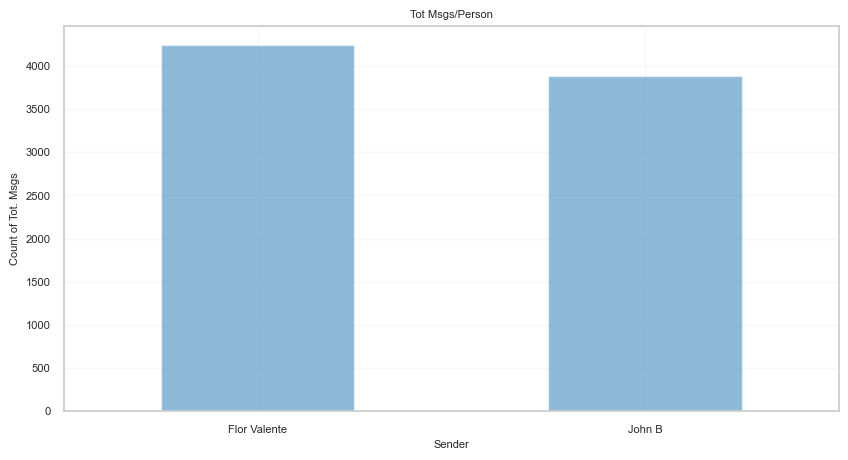

In [19]:
new_chart = new_df.groupby('sender')['text'].count() #new_df[['text','sender']].groupby(by=['sender'])['text'].count()
new_chart.plot.bar(stacked=False, figsize=(10, 5), rot=0, alpha=0.5, fontsize=8)

plt.grid(True, alpha=0.15)
plt.xlabel('Sender', fontsize=8)
plt.ylabel('Count of Tot. Msgs', fontsize=8)
plt.title('Tot Msgs/Person', fontsize=8)
plt.show()

---
## Plot count of messages by month

In [20]:
#Convert month to categorical data so that it starts from Month 10
# Define the desired order of months

new_df['month_name'] = new_df['date'].dt.strftime('%B')
month_order = ['October', 'November', 'December', 'January', 'February', 'March', 'April', 'May',
               'June', 'July', 'August', 'September']

# Convert month column to categorical data type with desired order
new_df['month_name'] = pd.Categorical(new_df['month_name'], categories=month_order, ordered=True)
monthly_grouped = new_df.groupby(['sender', 'month_name']).size().reset_index(name='count')

# Drop some months like July, August where there were no chats.
monthly_grouped = monthly_grouped.query('count > 0')

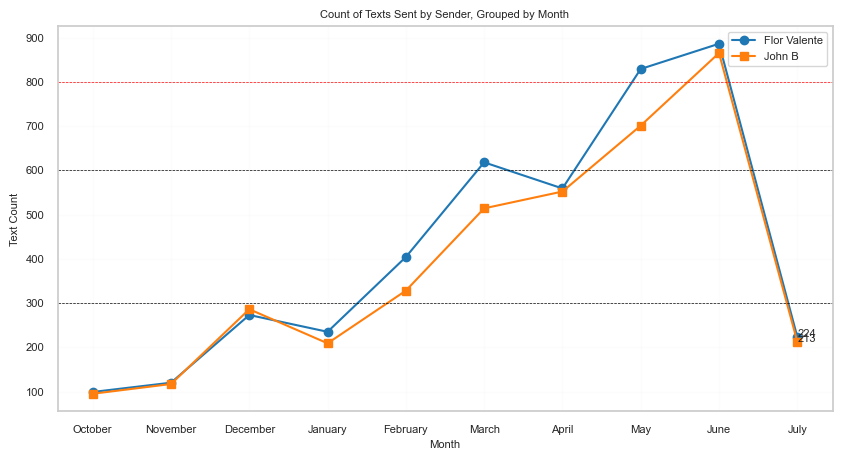

In [21]:
senders = monthly_grouped['sender'].unique()
markers = ['o', 's', '^', 'd']  # List of line markers

plt.figure(figsize=(10, 5))

for i, sender in enumerate(senders):
    
    sender_data = monthly_grouped[monthly_grouped['sender'] == sender]
    marker = markers[i % len(markers)]  # Select marker cyclically
    plt.plot(sender_data['month_name'], sender_data['count'], label=sender, marker=marker)

    # Show values on the last point
    last_value = sender_data['count'].iloc[-1]
    last_month = sender_data['month_name'].iloc[-1]
    plt.text(last_month, last_value, str(last_value), ha='left', va='baseline', fontsize=8)

plt.grid(True, alpha=0.05)

# Set plot properties
plt.xlabel('Month', fontsize=8)
plt.xticks(fontsize=8)

plt.ylabel('Text Count', fontsize=8)
plt.yticks(fontsize=8)

plt.title('Count of Texts Sent by Sender, Grouped by Month', fontsize=8)

plt.axhline(y=300, color='k', linestyle='--', linewidth=0.5)
plt.axhline(y=600, color='k', linestyle='--', linewidth=0.5)
plt.axhline(y=800, color='r', linestyle='--', linewidth=0.5)

plt.legend(fontsize=8)

# Show the plot
plt.show()

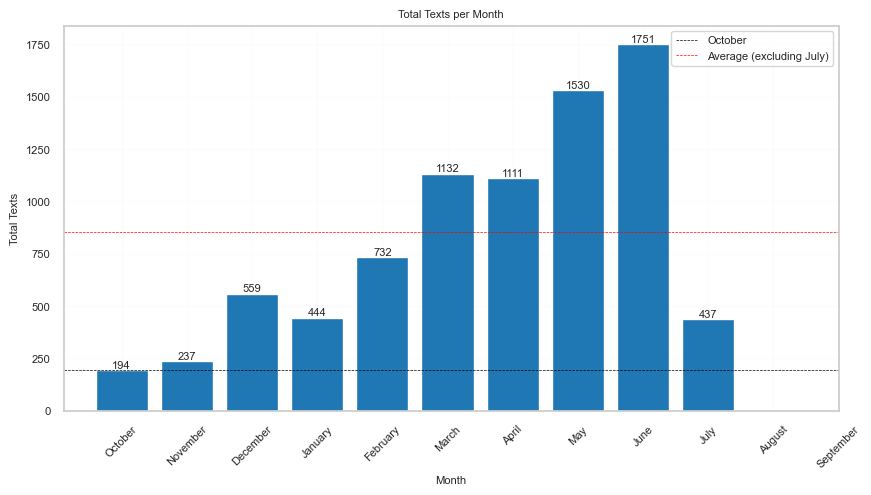

In [22]:
import calendar

# Group the dataframe by month_name and count the number of texts in each month
monthly_counts = new_df.groupby('month_name')['text'].count()

# Drop months with zero values
monthly_counts = monthly_counts[monthly_counts != 0]

# Get the month names and order them starting from October
month_names = list(calendar.month_name)[10:] + list(calendar.month_name)[1:10]

plt.figure(figsize=(10, 5))
# Plotting the bar chart
bars = plt.bar(monthly_counts.index, monthly_counts.values)

plt.xlabel('Month', fontsize=8)
plt.xticks(month_names, rotation=45, fontsize=8)  # Use month names for x-axis labels

plt.ylabel('Total Texts', fontsize=8)
plt.yticks(fontsize=8)

plt.axhline(y=194, color='k', linestyle='--', linewidth=0.5, label='October')

# Calculate the average excluding July
average_excluding_july = monthly_counts.drop('July').mean()

plt.axhline(y=average_excluding_july, color='r', linestyle='--', linewidth=0.5, label='Average (excluding July)')

plt.grid(True, alpha=0.05)
plt.title('Total Texts per Month', fontsize=8)

# Displaying the values on top of each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval, yval, ha='center', va='bottom', fontsize=8)

plt.legend(fontsize=8)  # Add a legend to display the labels for the lines

plt.show()


In [23]:
#new_df.to_csv("chat.csv")

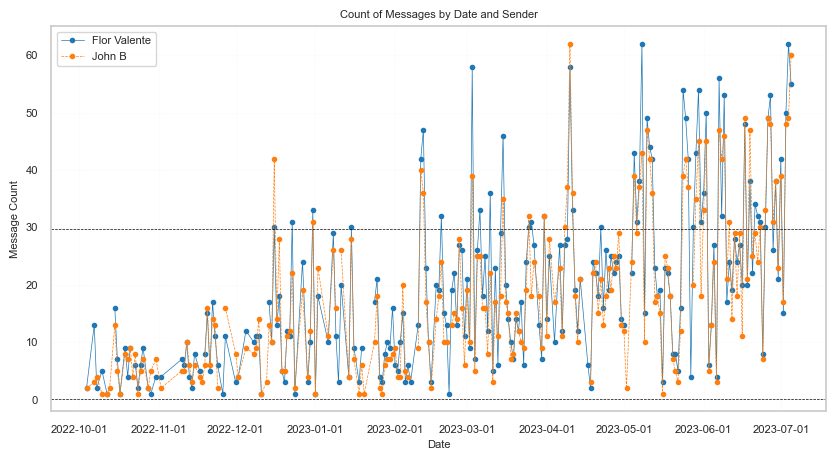

In [24]:
new_df[['date','sender','text']]

# Convert date column to datetime
new_df['date'] = pd.to_datetime(new_df['date'])

# Group by date and sender, and count the messages
timeline = new_df.groupby(['date', 'sender']).size().reset_index(name='count')

# Pivot the data to have sender1 and sender2 as separate columns
pivot_data = timeline.pivot(index='date', columns='sender', values='count')

# Plot the line charts
fig, ax = plt.subplots(figsize=(10, 5))
senders = pivot_data.columns

linestyles = ['-', '--']  # Specify different linestyles for each sender
markers = ['.']

for i, sender in enumerate(senders):
    linestyle = linestyles[i % len(linestyles)]  # Cycle through the linestyles
    marker = markers[i % len(markers)]
    ax.plot(pivot_data.index, pivot_data[sender], linestyle=linestyle, marker=marker, label=sender, linewidth=0.5)

# Set x-axis formatter to display full date
date_formatter = mdates.DateFormatter('%Y-%m-%d')
ax.xaxis.set_major_formatter(date_formatter)

plt.grid(True, alpha=0.05)

# Set plot properties
plt.xlabel('Date', fontsize=8)
plt.xticks(fontsize=8)

plt.ylabel('Message Count', fontsize=8)
plt.yticks(fontsize=8)

plt.axhline(y=0, color='k', linestyle='--', linewidth=0.5)
plt.axhline(y=avg_msgs_per_day, color='k', linestyle='--', linewidth=0.5)

plt.title('Count of Messages by Date and Sender', fontsize=8)
plt.legend(fontsize=8)

# Show the plot
plt.show()

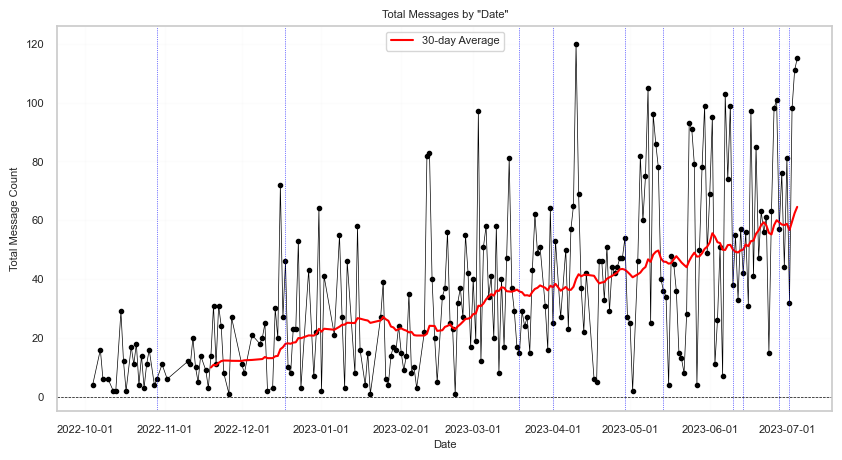

In [25]:
import datetime

random_dates = ['2022-10-29','2022-12-18','2023-03-19','2023-04-01', 
                '2023-04-29','2023-05-14','2023-06-10', '2023-06-14',
               '2023-06-28','2023-07-02']

# Group by date and sender, and count the messages
tot_timeline = new_df.groupby(['date', 'sender']).size().reset_index(name='count')

# Pivot the data to have sender1 and sender2 as separate columns
pivot_data = tot_timeline.pivot(index='date', columns='sender', values='count')

# Calculate the total messages by date
total_messages_by_date = pivot_data.sum(axis=1)

# Calculate the 30-day rolling average
rolling_average = total_messages_by_date.rolling(window=30).mean()

# Convert date strings to datetime objects
converted_dates = [datetime.datetime.strptime(date, '%Y-%m-%d').date() for date in random_dates]

# Plot the total messages by date
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(total_messages_by_date.index, total_messages_by_date, linestyle='-', marker='.', linewidth=0.5, color='k')

# Plot the rolling average line
ax.plot(total_messages_by_date.index, rolling_average, linestyle='-', color='r', label='30-day Average')

# Plot vertical lines for random dates
for date in converted_dates:
    ax.axvline(x=date, color='b', linestyle=':', linewidth=0.5)

# Set x-axis formatter to display full date
date_formatter = mdates.DateFormatter('%Y-%m-%d')
ax.xaxis.set_major_formatter(date_formatter)

plt.grid(True, alpha=0.05)

# Set plot properties
plt.xlabel('Date', fontsize=8)
plt.xticks(fontsize=8)

plt.ylabel('Total Message Count', fontsize=8)
plt.yticks(fontsize=8)

plt.axhline(y=0, color='k', linestyle='--', linewidth=0.5)

plt.title('Total Messages by "Date"', fontsize=8)

# Add a legend
plt.legend(fontsize=8)

# Show the plot
plt.show()


In [26]:
pd.set_option('display.max_colwidth', None)

#new_df.query("date == '2023-05-29'")[:50]
#new_df.query("text.str.contains('coffee', case=False) and date == '2023-05-12'")
#new_df.query("date == '2023-06-14'")
#new_df.query("text.str.contains('lanc', case=False)")

# 2023-04-24
# 2023-05-28
# 2023-05-29

---
### Text sentiment analysis? (flair)

In [27]:
# sentiment = []
# score = []

# def run_sentiment(text_input):
    
#     sentence = flair.data.Sentence(text_input)
    
#     flair_sentiment.predict(sentence)
#     feeling = sentence.labels[0].value
#     prob = sentence.score
    
#     sentiment.append(feeling)
#     score.append(prob)
    
    
# new_df['text'].apply(lambda x: run_sentiment(x))
# # Add 'sentiment' and 'score' columns to DataFrame
# new_df['sentiment'] = sentiment
# new_df['score'] = score

In [28]:
# new_df['sentiment_score'] = new_df.apply(lambda row: row['score'] if row['sentiment'] == 'POSITIVE' else -row['score'], axis=1)
# #new_df.head()

In [29]:
# sum_sentiment_score = new_df.groupby('sender')['sentiment_score'].sum()
# avg_sentiment_score = new_df.groupby('sender')['sentiment_score'].mean()

# # Print the sum and average sentiment scores
# for sender in sum_sentiment_score.index:
#     print("Sender:", sender)
#     print("Sum of Sentiment Score:", sum_sentiment_score[sender])
#     print("Average Sentiment Score:", avg_sentiment_score[sender])
#     print()

Sender: Flor Valente
Sum of Sentiment Score: 17.479371190071106
Average Sentiment Score: 0.004115698420077962

Sender: John B
Sum of Sentiment Score: 186.368861079216
Average Sentiment Score: 0.04803321161835464



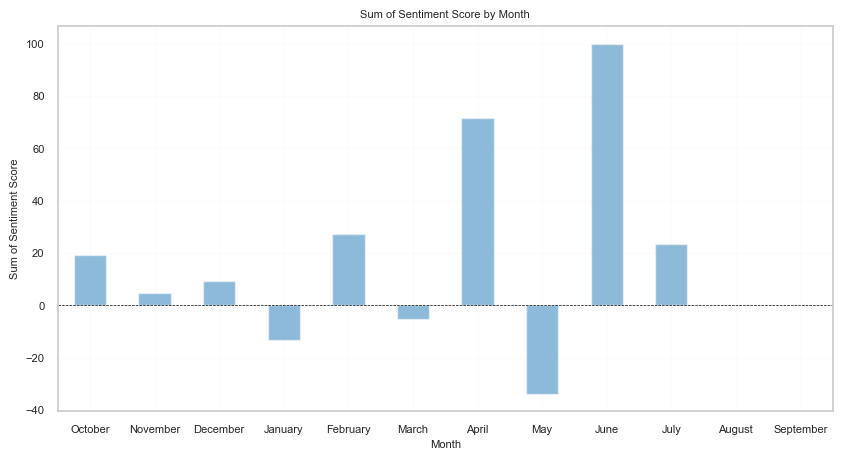

In [30]:
# # Calculate the sum of 'sentiment_score' by 'month_name'
# sum_sentiment_score_month = new_df.groupby('month_name')['sentiment_score'].sum()

# # Plot the bar chart
# sum_sentiment_score_month.plot.bar(figsize=(10, 5), rot=0, alpha=0.5)

# # Set plot properties
# plt.grid(True, alpha=0.05)
# plt.xlabel('Month', fontsize=8)
# plt.xticks(fontsize=8)

# plt.ylabel('Sum of Sentiment Score', fontsize=8)
# plt.yticks(fontsize=8)

# plt.axhline(y=0, color='k', linestyle='--', linewidth=0.5)

# plt.title('Sum of Sentiment Score by Month', fontsize=8)

# # Show the plot
# plt.show()


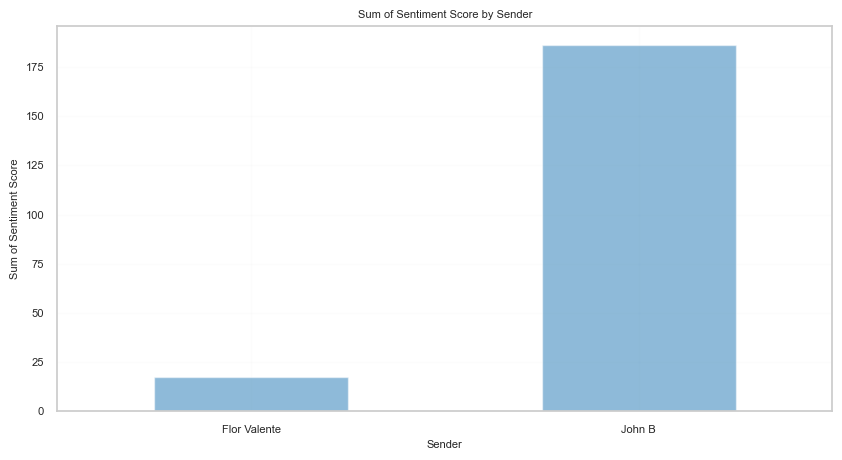

In [31]:
# # Calculate the sum of 'sentiment_score' by 'sender'
# sum_sentiment_score_sender = new_df.groupby('sender')['sentiment_score'].sum()

# # Plot the bar chart
# sum_sentiment_score_sender.plot.bar(figsize=(10, 5), rot=0, alpha=0.5)

# # Set plot properties
# plt.grid(True, alpha=0.05)
# plt.xlabel('Sender', fontsize=8)
# plt.xticks(fontsize=8)
# plt.ylabel('Sum of Sentiment Score', fontsize=8)
# plt.yticks(fontsize=8)
# plt.title('Sum of Sentiment Score by Sender', fontsize=8)

# # Show the plot
# plt.show()


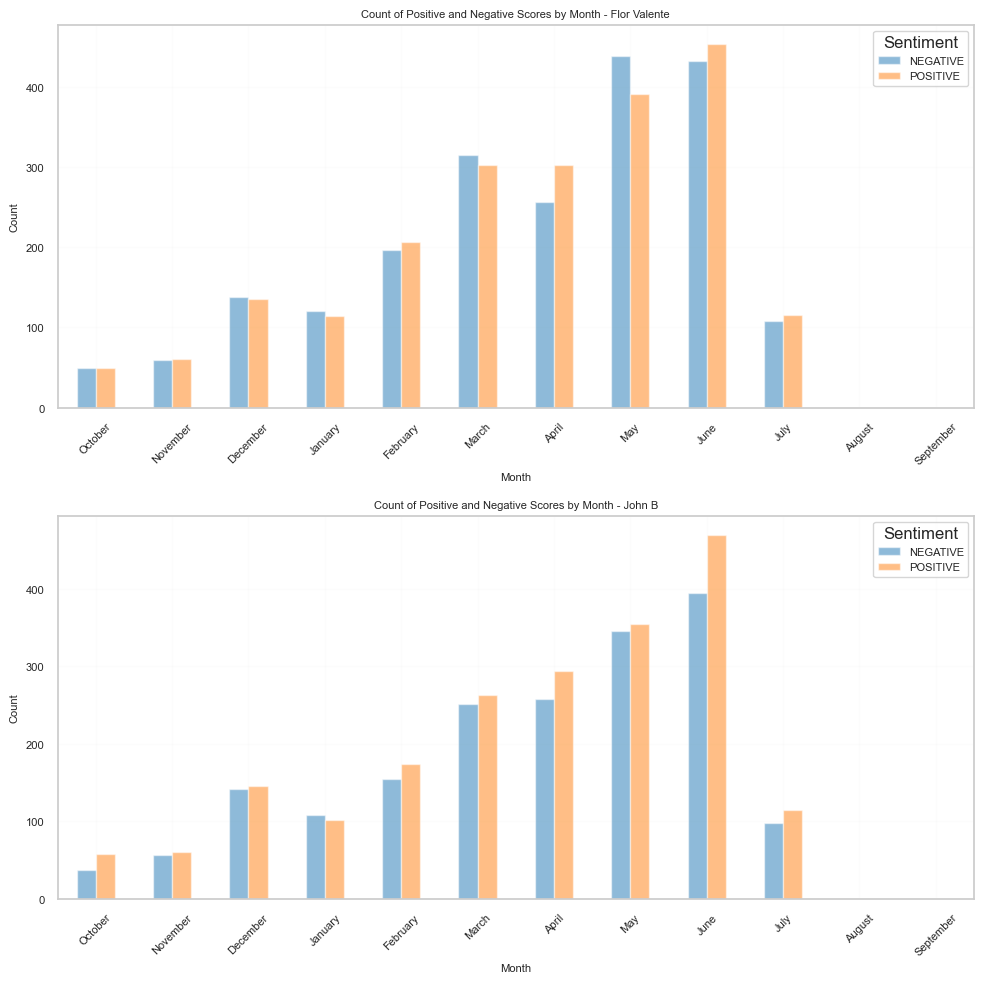

In [32]:

# # Group sentiment count by sender, month_name, and sentiment
# sentiment_count = new_df.groupby(['sender', 'month_name', 'sentiment']).size().unstack()

# # Get unique senders
# senders = sentiment_count.index.get_level_values('sender').unique()

# # Create subplots for each sender
# fig, axes = plt.subplots(nrows=len(senders), ncols=1, figsize=(10, 5 * len(senders)))

# # Iterate over senders and plot stacked bar chart for each sender
# for i, sender in enumerate(senders):
#     sender_data = sentiment_count.loc[sender]
#     sender_data.plot.bar(stacked=False, ax=axes[i], rot=0, alpha=0.5)

#     # Set plot properties for each subplot
#     axes[i].grid(True, alpha=0.05)
#     axes[i].set_xlabel('Month', fontsize=8)
#     axes[i].set_ylabel('Count', fontsize=8)
#     axes[i].set_title('Count of Positive and Negative Scores by Month - {}'.format(sender), fontsize=8)
#     axes[i].legend(title='Sentiment', loc='best', fontsize=8)
#     axes[i].tick_params(axis='x', labelrotation=45, labelsize=8)
#     axes[i].tick_params(axis='y', labelsize=8)

# # Adjust the layout of subplots
# plt.tight_layout()

# # Show the plot
# plt.show()


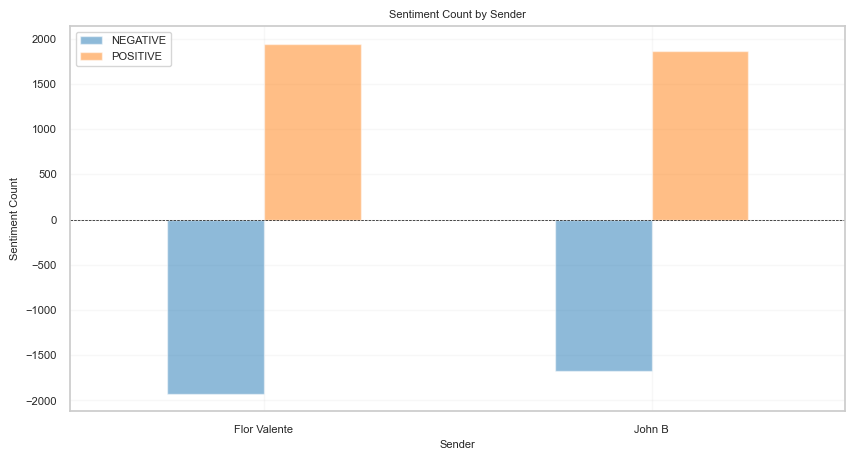

In [33]:
# # Group sentiment count by sender
# #sentiment_score = new_df.groupby(['sender', 'sentiment']).size().unstack()
# sentiment_score = new_df.groupby(['sender', 'sentiment'])['sentiment_score'].sum().unstack()

# # Plot stacked bar chart
# sentiment_score.plot.bar(stacked=False, figsize=(10, 5), rot=0, alpha=0.5)

# # Set plot properties
# plt.grid(True, alpha=0.15)

# plt.xlabel('Sender', fontsize=8)
# plt.xticks(fontsize=8)

# plt.ylabel('Sentiment Count', fontsize=8)
# plt.yticks(fontsize=8)

# plt.axhline(y=0, color='k', linestyle='--', linewidth=0.5)

# plt.title('Sentiment Count by Sender', fontsize=8)
# plt.legend(loc='best', fontsize=8)

# # Show the plot
# plt.show()

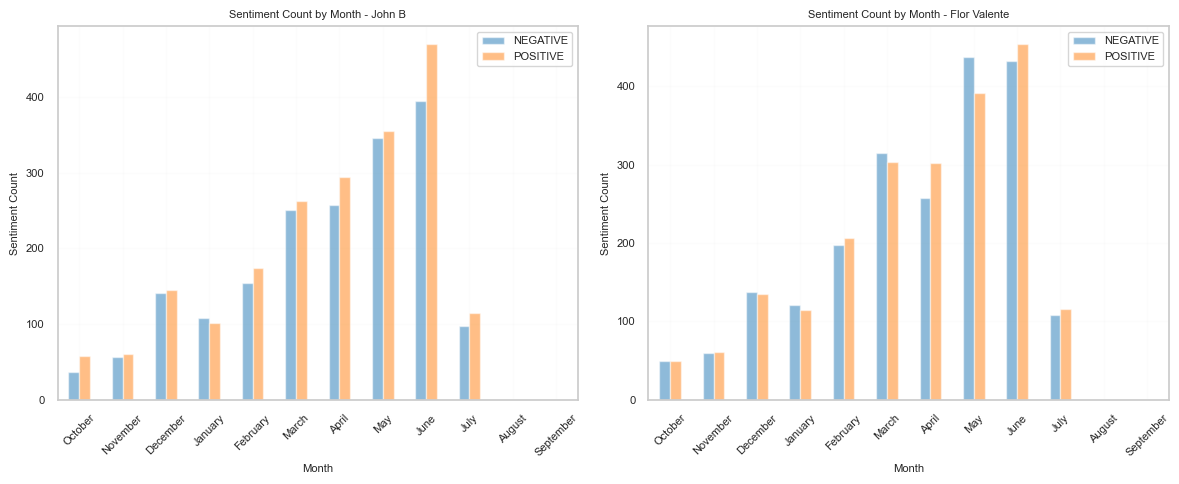

In [34]:
# # Define the sender names
# sender_names = ['John B', 'Flor Valente']

# # Create a figure with two subplots
# fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

# # Iterate over the sender names and corresponding subplots
# for i, sender_name in enumerate(sender_names):
#     # Filter the dataframe for the current sender
#     sender_df = new_df[new_df['sender'] == sender_name]

#     # Group sentiment count by month and sentiment
#     sentiment_score = sender_df.groupby(['month_name', 'sentiment']).size().unstack()

#     # Plot stacked bar chart on the corresponding subplot
#     sentiment_score.plot.bar(ax=axes[i], stacked=False, rot=0, alpha=0.5)

#     # Set plot properties for the current subplot
#     axes[i].grid(True, alpha=0.05)
#     axes[i].set_xlabel('Month', fontsize=8)
#     axes[i].set_ylabel('Sentiment Count', fontsize=8)
#     axes[i].set_title('Sentiment Count by Month - {sender_name}'.format(sender_name=sender_name), fontsize=8)
#     axes[i].legend(loc='best', fontsize=8)

#     # Set tick label font size and rotation
#     axes[i].tick_params(axis='x', labelrotation=45, labelsize=8)
#     axes[i].tick_params(axis='y', labelsize=8)

# # Adjust the layout of subplots
# plt.tight_layout()

# # Show the plot
# plt.show()


## Sentiment breakdown by month
---

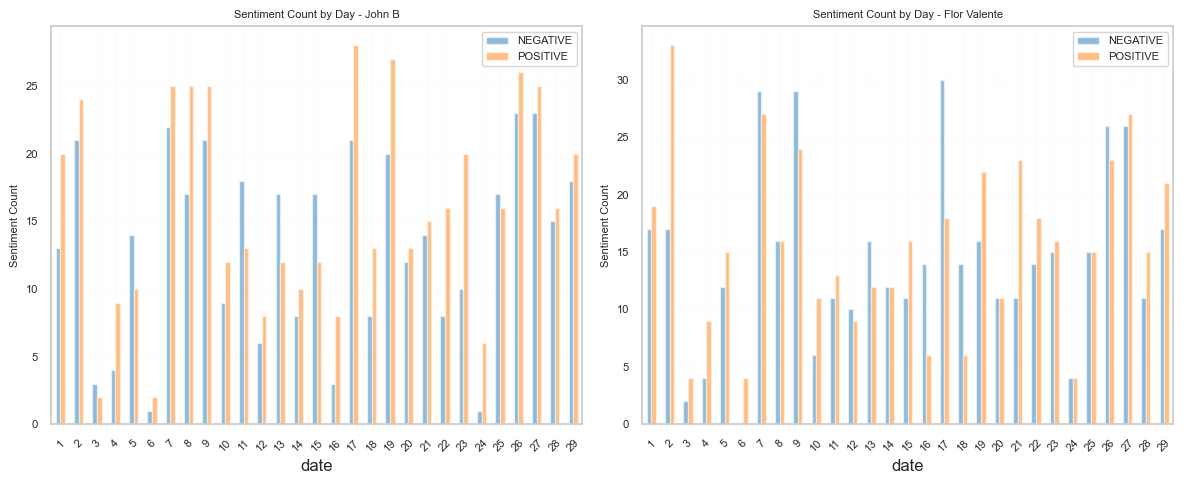

In [35]:
# # Define the sender names
# sender_names = ['John B', 'Flor Valente']

# # Define the start and end dates for filtering
# start_date = '2023-06-01'
# end_date = '2023-06-29'

# # Create a figure with two subplots
# fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

# # Iterate over the sender names and corresponding subplots
# for i, sender_name in enumerate(sender_names):
#     # Filter the dataframe for the current sender and date range
#     sender_df = new_df[(new_df['sender'] == sender_name) & (new_df['date'] >= start_date) & (new_df['date'] <= end_date)]

#     # Group sentiment count by day of the month and sentiment
#     sentiment_score = sender_df.groupby([sender_df['date'].dt.day, 'sentiment']).size().unstack()

#     # Plot stacked bar chart on the corresponding subplot
#     sentiment_score.plot.bar(ax=axes[i], stacked=False, rot=0, alpha=0.5)

#     # Set plot properties for the current subplot
#     axes[i].grid(True, alpha=0.05)
#     axes[i].set_ylabel('Sentiment Count', fontsize=8)
#     axes[i].set_title('Sentiment Count by Day - {sender_name}'.format(sender_name=sender_name), fontsize=8)
#     axes[i].legend(loc='best', fontsize=8)

#     # Set x-axis tick labels
#     axes[i].set_xticklabels(sentiment_score.index, fontsize=8, rotation=45)

#     # Set tick label font size for y-axis
#     axes[i].tick_params(axis='y', labelsize=8)

# # Adjust the layout of subplots
# plt.tight_layout()

# # Show the plot
# plt.show()


---

## Message Count
---

In [35]:
try:
    # Convert the time column to proper time format without seconds
    new_df['time'] = pd.to_datetime(new_df['time'], format='%H:%M').dt.time

    # Create the datetime column by combining the date and time columns
    new_df['datetime'] = pd.to_datetime(new_df['date']) + pd.to_timedelta(new_df['time'].astype(str))
    
    print("Conversion to datetime is done...")
    
except ValueError:
    # Skip the code execution if ValueError occurs
    print("Conversion to datetime already done...")
    pass

Conversion to datetime is done...


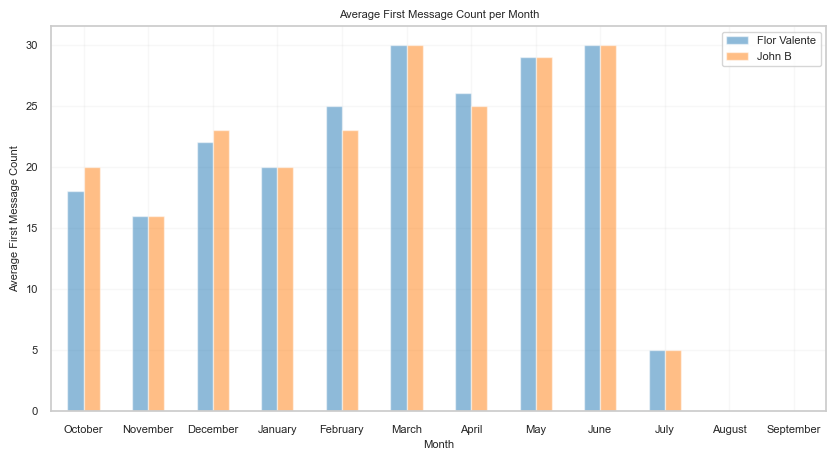

In [36]:
# Sort dataframe by date and time
df = new_df.sort_values(['date', 'time','month_name'])

# Get the first message of the day for each sender
first_message_df = df.groupby(['date', 'sender']).first().reset_index()

# Calculate the monthly average for each sender
monthly_avg_df = first_message_df.pivot_table(index='month_name', columns='sender', values='text', aggfunc='count')

# Plot the chart
monthly_avg_df.plot(kind='bar', stacked=False, figsize=(10, 5), rot=0, alpha=0.5)

# Customize the chart
plt.grid(True, alpha=0.15)
plt.xlabel('Month', fontsize=8)
plt.xticks(fontsize=8)

plt.ylabel('Average First Message Count', fontsize=8)
plt.yticks(fontsize=8)

plt.title('Average First Message Count per Month', fontsize=8)
plt.legend(fontsize=8)

plt.show()

---
## Get response times

In [37]:
#data.head()

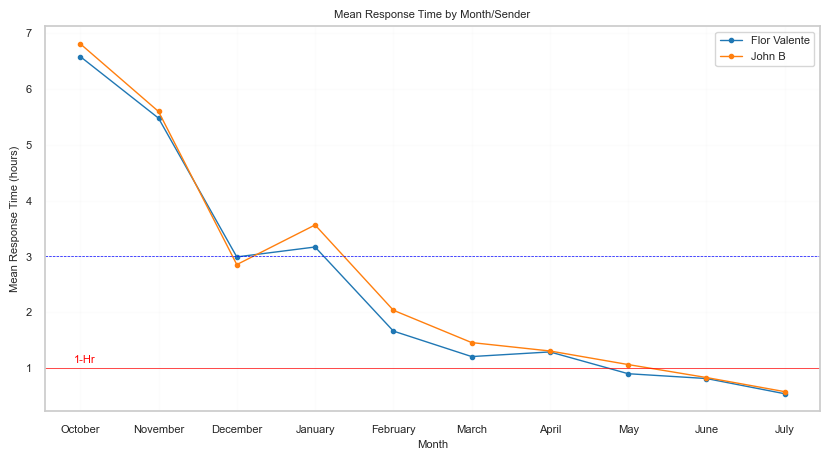

In [38]:
# Calculate the response time in minutes
new_df['response_time'] = new_df.groupby('sender')['datetime'].diff().dt.total_seconds() / 60

# Convert response time to hours
new_df['response_time'] /= 60

# Group by sender and month, and calculate the average response time
average_response_time = new_df.groupby(['sender', 'month_name'])['response_time'].mean().reset_index()

# Plot the average response times by month for each sender
senders = average_response_time['sender'].unique()

plt.figure(figsize=(10, 5))
for sender in senders:
    sender_data = average_response_time[average_response_time['sender'] == sender]
    plt.plot(sender_data['month_name'], sender_data['response_time'], marker='.', label=sender, linewidth=1)

plt.grid(True, alpha=0.05)
plt.axhline(y=1, color='r', linestyle='-',linewidth=0.5)
plt.text(0.05, 1 + 0.05, '1-Hr', color='r', fontsize=8, ha='center', va='bottom')

plt.axhline(y=3, color='b', linestyle='--',linewidth=0.5)
# Set plot properties
plt.xlabel('Month', fontsize=8)
plt.xticks(fontsize=8)

plt.ylabel('Mean Response Time (hours)', fontsize=8)
plt.yticks(fontsize=8)

plt.title('Mean Response Time by Month/Sender', fontsize=8)
plt.legend(fontsize=8)

# Show the plot
plt.show()

In [39]:
# Filter the dataframe to contain only Sender1 and Sender2
sender1_response_time = new_df[new_df['sender'] == 'Flor Valente']['response_time']
sender2_response_time = new_df[new_df['sender'] == 'John B']['response_time']

# Calculate the average response time for Sender1 and Sender2
average_response_time_sender1 = sender1_response_time.mean()
average_response_time_sender2 = sender2_response_time.mean()

# Calculate the overall average response time between Sender1 and Sender2
overall_average_response_time = new_df['response_time'].mean()

print(f"Average response time for Flor: {average_response_time_sender1:.2f}")
print(f"Average response time for John: {average_response_time_sender2:.2f}")
print(f"Overall average response time between Flor and John: {overall_average_response_time:.2f}")


Average response time for Flor: 1.55
Average response time for John: 1.70
Overall average response time between Flor and John: 1.62


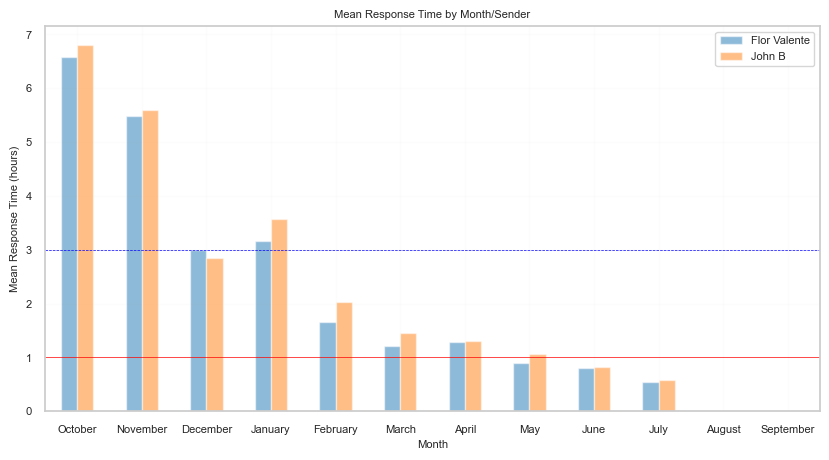

In [40]:
# Group by sender and month, and calculate the average response time
average_response_time = new_df.groupby(['month_name', 'sender'])['response_time'].mean().unstack()

# Plot the average response times by month for each sender
average_response_time.plot.bar(figsize=(10, 5), alpha=0.5)

# Set plot properties
plt.grid(True, alpha=0.05)
plt.axhline(y=1, color='r', linestyle='-', linewidth=0.5)
plt.axhline(y=3, color='b', linestyle='--', linewidth=0.5)

plt.xlabel('Month', fontsize=8)
plt.xticks(fontsize=8, rotation='horizontal')

plt.ylabel('Mean Response Time (hours)', fontsize=8)
plt.yticks(fontsize=8)

plt.title('Mean Response Time by Month/Sender', fontsize=8)
plt.legend(fontsize=8)

# Show the plot
plt.show()


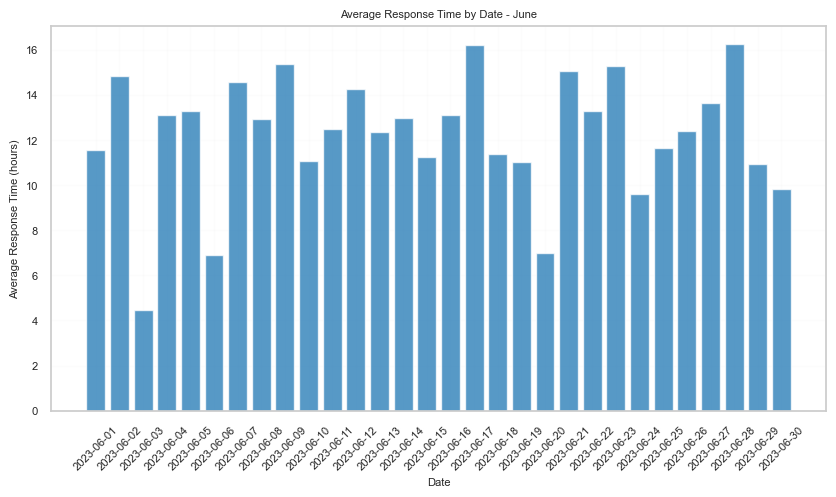

In [41]:

# Filter the dataframe for the desired month
selected_month = 'June'
filtered_df = df.query("month_name == @selected_month")

# Calculate the average response time by dates in the selected month
average_response_time = filtered_df.groupby('date')['datetime'].apply(lambda x: (x.max() - x.min()).seconds / 3600)

# Plotting the bar chart
plt.figure(figsize=(10, 5))
plt.bar(average_response_time.index, average_response_time.values, alpha=0.75)

plt.xlabel('Date', fontsize=8)
plt.xticks(average_response_time.index, fontsize=8, rotation=45)

plt.ylabel('Average Response Time (hours)', fontsize=8)
plt.yticks(fontsize=8)

plt.grid(True, alpha=0.05)
plt.title(f'Average Response Time by Date - {selected_month}', fontsize=8)

plt.show()


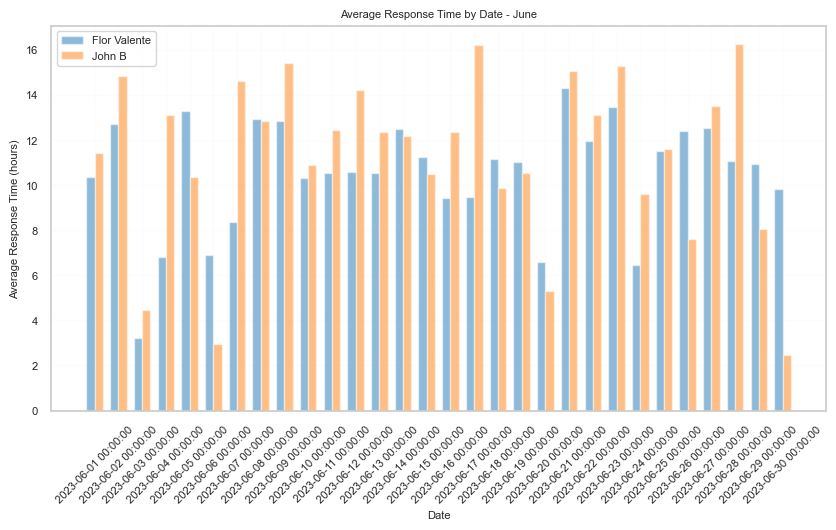

In [42]:
# Filter the dataframe for the desired month and senders
selected_month = 'June'
selected_senders = ['Flor Valente', 'John B']  # Replace with the actual sender names
filtered_df = df.query("month_name == @selected_month and sender in @selected_senders")

# Calculate the average response time by dates in the selected month and for the selected senders
average_response_time = filtered_df.groupby(['date', 'sender'])['datetime'].apply(lambda x: (x.max() - x.min()).seconds / 3600)

# Pivot the data to have senders as columns and dates as rows
pivot_table = average_response_time.unstack()

# Plotting the bar chart
plt.figure(figsize=(10, 5))
width = 0.35
x = range(len(pivot_table.index))

# Calculate the offset for each sender's bars
offset = width / 2 * (len(selected_senders) - 1)

# Plot the bars for each sender
for i, sender in enumerate(pivot_table.columns):
    plt.bar([xi + i * width - offset for xi in x], pivot_table[sender], width, label=sender, alpha=0.50)

plt.xlabel('Date', fontsize=8)
plt.xticks(x, pivot_table.index, fontsize=8, rotation=45)

plt.ylabel('Average Response Time (hours)', fontsize=8)
plt.yticks(fontsize=8)

plt.grid(True, alpha=0.05)
plt.title(f'Average Response Time by Date - {selected_month}', fontsize=8)
plt.legend(fontsize=8)

plt.show()


---
## Average # of messages sent per person

In [43]:
# Filter the dataframe for Person_One and Person_Two
person_one = 'Flor Valente'
person_two = 'John B'
filtered_df = new_df[new_df['sender'].isin([person_one, person_two])]

# Extract the hour and date from the datetime field
filtered_df['hour'] = filtered_df['datetime'].dt.hour
filtered_df['date'] = filtered_df['datetime'].dt.date

# Extract the day of the week from the date field
filtered_df['day_of_week'] = filtered_df['datetime'].dt.day_name()

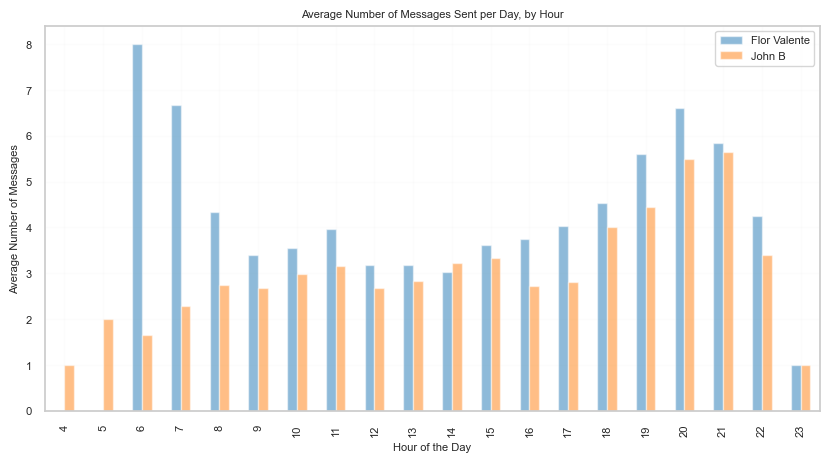

In [44]:
fdf = filtered_df.query('month_name == "May"')

# Calculate the average number of messages sent per day, by the hour, for Person_One and Person_Two
avg_messages_per_hour = filtered_df.groupby(['sender', 'hour', 'date']).size().reset_index(name='message_count')
avg_messages_per_hour = avg_messages_per_hour.groupby(['sender', 'hour'])['message_count'].mean().reset_index()

# Pivot the data to have senders as separate columns
pivot_data = avg_messages_per_hour.pivot(index='hour', columns='sender', values='message_count')

# Plot the bar chart
pivot_data.plot(kind='bar', figsize=(10, 5), alpha=0.5)
plt.grid(True, alpha = 0.05)
# Set plot properties
plt.xlabel('Hour of the Day', fontsize=8)
plt.xticks(fontsize=8)

plt.ylabel('Average Number of Messages', fontsize=8)
plt.yticks(fontsize=8)

plt.title('Average Number of Messages Sent per Day, by Hour', fontsize=8)
plt.legend(fontsize=8)

# Show the plot
plt.show()


---
## Avg. messages per week

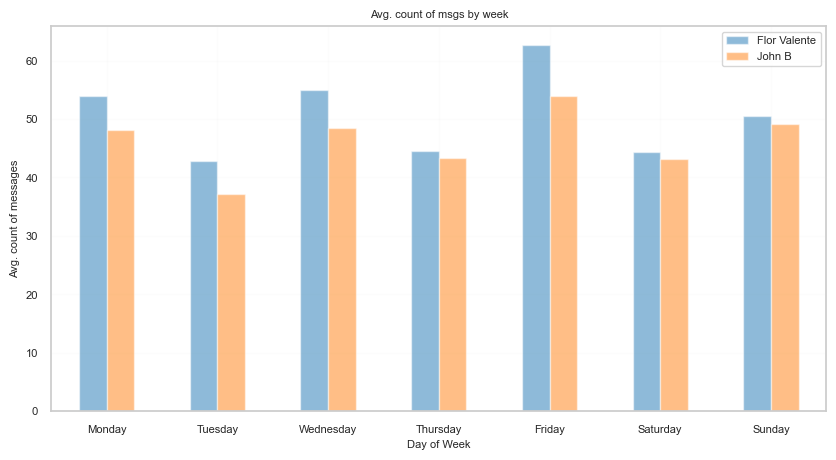

In [45]:
average_texts = filtered_df.groupby(['month_name', 'sender', 'day_of_week'])['text'].count().reset_index()
average_texts = average_texts.pivot_table(index=['month_name', 'day_of_week'], columns='sender', values='text').reset_index()

# Group the dataframe by 'day_of_week' and calculate the mean text counts for 'Person_One' and 'Person_Two'
average_texts_day = average_texts.groupby('day_of_week')[['Flor Valente', 'John B']].mean()

# Reorder the index to start from Monday
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
average_texts_day = average_texts_day.reindex(weekday_order)

# Plot the bar chart
average_texts_day.plot(kind='bar', figsize=(10, 5), rot=0, alpha=0.5)

# Set plot properties
plt.grid(True, alpha=0.05)

plt.xlabel('Day of Week', fontsize=8)
plt.xticks(fontsize=8)

plt.ylabel('Avg. count of messages', fontsize=8)
plt.yticks(fontsize=8)

plt.title('Avg. count of msgs by week', fontsize=8)
plt.legend(fontsize=8)

# Show the plot
plt.show()


In [46]:
# Filter the dataframe for Person_One and Person_Two
person_one_data = new_df[new_df['sender'] == 'Flor Valente']
person_two_data = new_df[new_df['sender'] == 'John B']

# Find the date where Person_One messaged the most
person_one_most_messages_date = person_one_data['date'].value_counts().idxmax()
person_one_messages_count = person_one_data['date'].value_counts().max()

# Find the date where Person_Two messaged the most
person_two_most_messages_date = person_two_data['date'].value_counts().idxmax()
person_two_messages_count = person_two_data['date'].value_counts().max()

print("Date with the most messages for John B:", person_one_most_messages_date,'They sent'
      , person_one_messages_count, 'messages.')

print("\nDate with the most messages for Florencia Valente:", person_two_most_messages_date, 'They sent',
     person_two_messages_count, 'messages.\n')

print('-'*50)
target_date = '2023-04-10'  # Replace with your desired date

# Filter the dataframe for the target date and Person_One and Person_Two
get_sentiment = new_df[new_df['date'] == target_date]
person_one_data = get_sentiment[get_sentiment['sender'] == 'John B']
person_two_data = get_sentiment[get_sentiment['sender'] == 'Flor Valente']

# Calculate the sentiment count for Person_One and Person_Two
# person_one_sentiment_count = person_one_data['sentiment'].value_counts()
# person_two_sentiment_count = person_two_data['sentiment'].value_counts()

# print('\nFor Date:', target_date,'\n')
# print("Sentiment count for John B:")
# print(person_one_sentiment_count.to_string(),'\n')
# print('.'*50)
# print("\nSentiment count for Flor Valente:")
# print(person_two_sentiment_count.to_string())

Date with the most messages for John B: 2023-07-04 00:00:00 They sent 62 messages.

Date with the most messages for Florencia Valente: 2023-04-10 00:00:00 They sent 62 messages.

--------------------------------------------------


---
## Other info

- Who writes the most
- Most active chat date
- Other stats
- Avg. messages per person

In [47]:
# Extract the number of words from the text column
df['num_words'] = new_df['text'].str.split().str.len()

# Calculate the average number of words per message for each sender
avg_words_per_message = df.groupby('sender')['num_words'].mean()

# Find the sender with the highest average number of words per message
sender_with_most_words = avg_words_per_message.idxmax()

# Display the result
print("Sender with the highest average number of words per message:", sender_with_most_words)

Sender with the highest average number of words per message: John B


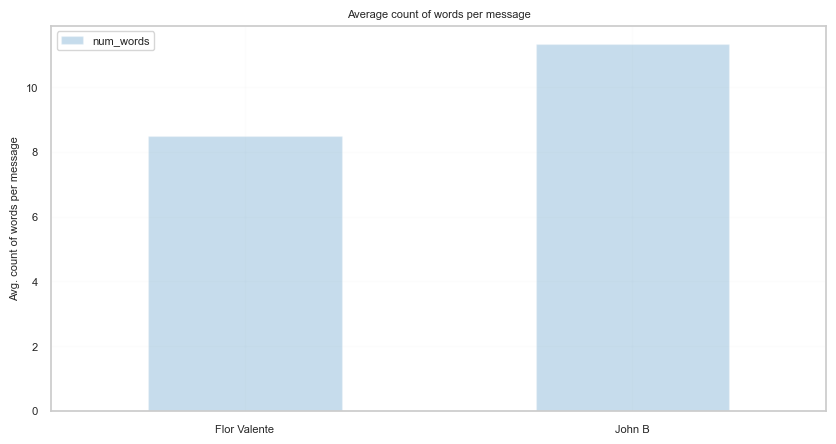

In [48]:
avg_words_per_message.plot(kind='bar', grid=True, figsize=(10, 5), alpha=0.25, rot=360, fontsize=8)

plt.grid(True, alpha=0.05)
plt.title("Average count of words per message", fontsize=8)
plt.ylabel('Avg. count of words per message', fontsize=8)
plt.xlabel('', fontsize=8)
plt.legend(fontsize=8)
plt.show()

In [49]:
# Group the dataframe by date and calculate the total messages for each day
daily_messages = new_df.groupby('date')['sender'].count()

# Find the day with the highest total messages
day_with_highest_messages = daily_messages.idxmax()
highest_messages_count = daily_messages.max()

print("Day with the highest total messages:", day_with_highest_messages.date())
print("Total number of messages on that day:", highest_messages_count)

Day with the highest total messages: 2023-04-10
Total number of messages on that day: 120


In [50]:

min_date = new_df['date'].min()  # Find the minimum date
max_date = new_df['date'].max()  # Find the maximum date

total_days_chat = new_df['date'].dt.date.nunique()

total_days = (max_date - min_date).days  # Calculate the total number of days

act_total_days = total_days  # Assign the total number of days to the variable 'act_total_days'

tot_pct = (total_days_chat/act_total_days)*100

print("First Chat Date:", min_date.date())
print("Last Chat Date:", max_date.date())
print("Total Days in Chat:", total_days_chat)
print("Actual Days:", act_total_days)
print(f"Percentage of days communication: {tot_pct:.2f}%")


First Chat Date: 2022-10-04
Last Chat Date: 2023-07-05
Total Days in Chat: 227
Actual Days: 274
Percentage of days communication: 82.85%


In [51]:
result = df.groupby(['date', 'sender']).size().reset_index(name='message_count')
average_message_count = result.groupby('sender')['message_count'].mean()

print('Messages sent per person\n',average_message_count.to_string())

Messages sent per person
 sender
Flor Valente    19.217195
John B          17.556561


In [52]:
new_df.query('text.str.contains("vinho", case=False, na=False)')
#new_df.query('date == "2023-05-08"')[21:50]

,text,date,time,sender,month,month_name,datetime,response_time
6083,Hmmm not really. I like vinho verde it’s a light refreshing wine…nice on a sunny day,2023-05-29,20:17:00,Flor Valente,5,May,2023-05-29 20:17:00,0.0


### Timeline
---

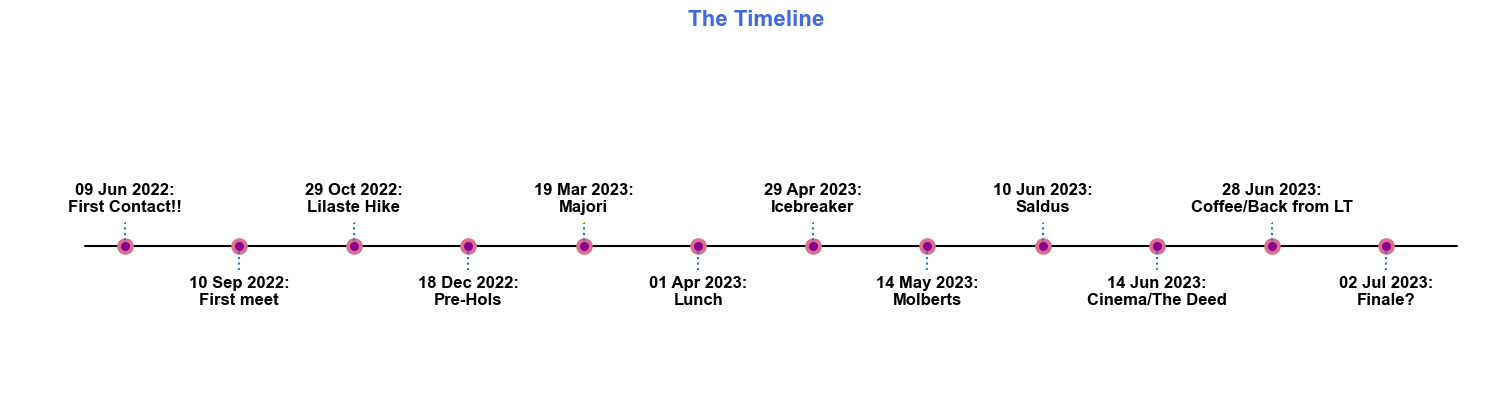

In [53]:
import matplotlib.pyplot as plt
from datetime import date, timedelta
import numpy as np

dates = [
    date(2022, 6, 9), date(2022, 9, 10), date(2022, 10, 29), date(2022, 12, 18),
    date(2023, 3, 19), date(2023, 4, 1), date(2023, 4, 29),
    date(2023, 5, 14), date(2023, 6, 10), date(2023, 6, 14), date(2023, 6, 28),
    date(2023, 7, 2)
]

min_date = date(np.min(dates).year - 2, np.min(dates).month, np.min(dates).day)
max_date = date(np.max(dates).year + 2, np.max(dates).month, np.max(dates).day)

labels = [
    'First Contact!!', 'First meet', 'Lilaste Hike', 'Pre-Hols', 'Majori', 'Lunch',
    'Icebreaker', 'Molberts', 'Saldus', 'Cinema/The Deed', 'Coffee/Back from LT',
    'Finale?'
]

# labels with associated dates
labels = ['{0:%d %b %Y}:\n{1}'.format(d, l) for l, d in zip(labels, dates)]

fig, ax = plt.subplots(figsize=(15, 4), constrained_layout=True)
ax.set_ylim(-2, 2.75)
ax.set_xlim(min_date, max_date)
ax.axhline(0, xmin=0.05, xmax=0.97, c='black', zorder=1)

# Calculate desired spacing between events
days_range = (max_date - min_date).days
spacing = timedelta(days=days_range / (len(dates) + 1))

scatter_x = [min_date + (i + 1) * spacing for i in range(len(dates))]

ax.scatter(scatter_x, np.zeros(len(dates)), s=120, c='palevioletred', zorder=2)
ax.scatter(scatter_x, np.zeros(len(dates)), s=30, c='darkmagenta', zorder=3)

label_offsets = np.zeros(len(dates))
label_offsets[::2] = 0.45
label_offsets[1::2] = -0.75

for i, (l, d) in enumerate(zip(labels, dates)):
    x_pos = min_date + (i + 1) * spacing
    ax.text(x_pos, label_offsets[i], l, ha='center', fontweight='bold', color='black', fontsize=12)
    stems = np.zeros(len(dates))
    stems[::2] = 0.3
    stems[1::2] = -0.3
    _ = ax.stem([x_pos], [stems[i]], linefmt=':', basefmt=' ', markerfmt=',', bottom=0.0, label='_nolegend_')

# hide lines around chart
for spine in ["left", "top", "right", "bottom"]:
    ax.spines[spine].set_visible(False)

# hide tick labels
ax.set_xticks([])
ax.set_yticks([])

ax.set_title('The Timeline', fontweight="bold", fontsize=16, color='royalblue')

plt.show()


In [54]:
pct_meets = len(labels)/act_total_days
pct_meets = pct_meets * 100

print(f"Percentage of rendezvous: {pct_meets:.2f}%")

Percentage of rendezvous: 4.38%


---

In [55]:


# # Assuming the DataFrame is already loaded as new_df

# # Group data by sender and calculate message frequency
# sender_message_counts = new_df['sender'].value_counts()

# # Group data by sender and calculate average response time
# sender_avg_response_time = new_df.groupby('sender')['response_time'].mean()

# # Create bar plots to compare message frequency and response time among senders
# plt.figure(figsize=(10, 5))
# plt.subplot(1, 2, 1)
# sender_message_counts.plot(kind='bar')
# plt.title('Message Frequency by Sender')
# plt.xlabel('Sender')
# plt.ylabel('Message Count')

# plt.subplot(1, 2, 2)
# sender_avg_response_time.plot(kind='bar')
# plt.title('Average Response Time by Sender')
# plt.xlabel('Sender')
# plt.ylabel('Average Response Time')

# plt.tight_layout()
# plt.show()


In [56]:
import emoji

# Assuming the DataFrame is already loaded as new_df

# Function to count the number of emojis in a text
def count_emojis(text):
    return len([c for c in text if c in emoji.EMOJI_DATA])

# Apply the count_emojis function to the 'text' column and create a new column for emoji counts
new_df['emoji_count'] = new_df['text'].apply(count_emojis)

# Group data by sender and sum the emoji counts
sender_emoji_counts = new_df.groupby('sender')['emoji_count'].sum()

# Find the sender who sends the most emojis
sender_with_most_emojis = sender_emoji_counts.idxmax()
most_emojis_count = sender_emoji_counts.max()

print(f"The sender who sends the most emojis is: {sender_with_most_emojis}")
print(f"They sent a total of {most_emojis_count} emojis.")


The sender who sends the most emojis is: John B
They sent a total of 1643 emojis.


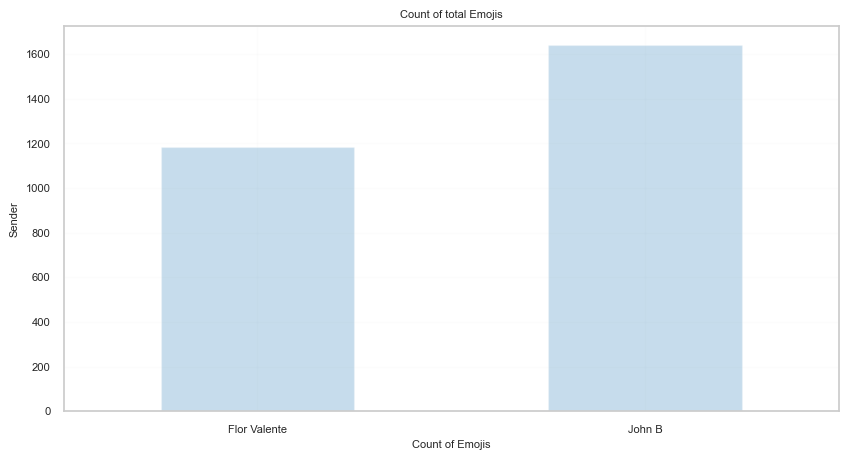

In [57]:
sender_emoji_counts.plot(kind='bar', grid=True, figsize=(10, 5), alpha=0.25, rot=360, fontsize=8)

plt.grid(True, alpha=0.05)
plt.title("Count of total Emojis", fontsize=8)
plt.xlabel('Count of Emojis', fontsize=8)
plt.ylabel('Sender', fontsize=8)
plt.show()

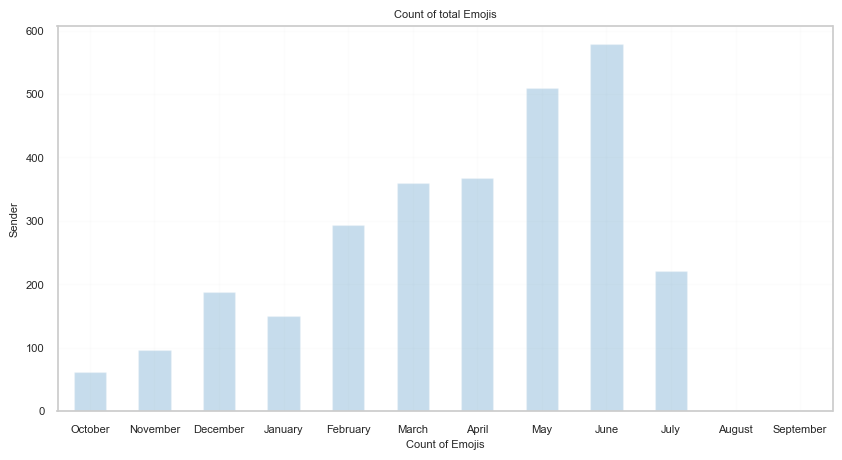

In [58]:
emoji_counts_per_month = new_df.groupby('month_name')['emoji_count'].sum()

emoji_counts_per_month.plot(kind='bar', grid=True, figsize=(10, 5), alpha=0.25, rot=360, fontsize=8)

plt.grid(True, alpha=0.05)
plt.title("Count of total Emojis", fontsize=8)
plt.xlabel('Count of Emojis', fontsize=8)
plt.ylabel('Sender', fontsize=8)
plt.show()

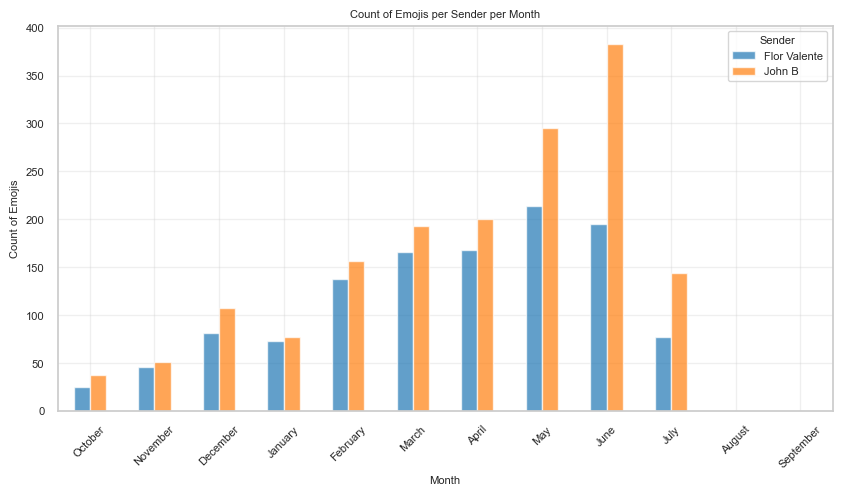

In [59]:
# Apply the count_emojis function to the 'text' column and create a new column for emoji counts
new_df['emoji_count'] = new_df['text'].apply(count_emojis)

# Group data by month_name and sender, and sum the emoji counts for each month and sender
emoji_counts_per_month_sender = new_df.groupby(['month_name', 'sender'])['emoji_count'].sum()

# Reshape the data to have month_name as columns and sender as rows
emoji_counts_per_month_sender = emoji_counts_per_month_sender.unstack(level='sender', fill_value=0)

# Plot the count of emojis for each sender in each month
emoji_counts_per_month_sender.plot(kind='bar', grid=True, figsize=(10, 5), alpha=0.7, rot=45, fontsize=8)

plt.grid(True, alpha=0.3)
plt.title("Count of Emojis per Sender per Month", fontsize=8)
plt.xlabel('Month', fontsize=8)
plt.ylabel('Count of Emojis', fontsize=8)
plt.legend(title='Sender', fontsize=8, title_fontsize=8)
plt.show()


Count of 'John%' or 'Flor%' mentions per sender:
sender
Flor Valente    20
John B          92
Name: name_mentions, dtype: int64


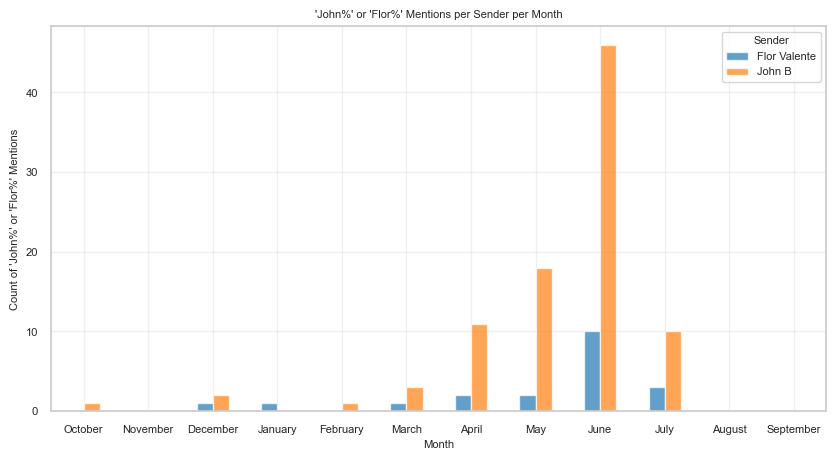

In [60]:
import re

# Assuming the DataFrame is already loaded as new_df

# Function to count the occurrences of 'John%' or 'Flor%' in a text
def count_mentions(text):
    return len(re.findall(r'\b(?:John|Flor)\S*', text))

# Apply the count_mentions function to the 'text' column and create a new column for the counts
new_df['name_mentions'] = new_df['text'].apply(count_mentions)

# Group data by sender and sum the name mentions for each sender
sender_name_mentions = new_df.groupby('sender')['name_mentions'].sum()

# Print the count of 'John%' or 'Flor%' mentions per sender
print("Count of 'John%' or 'Flor%' mentions per sender:")
print(str(sender_name_mentions))

# Group data by month_name and sender, and sum the name mentions for each month and sender
name_mentions_per_month_sender = new_df.groupby(['month_name', 'sender'])['name_mentions'].sum()

# Reshape the data to have month_name as columns and sender as rows
name_mentions_per_month_sender = name_mentions_per_month_sender.unstack(level='sender', fill_value=0)

# Plot the count of 'John%' or 'Flor%' mentions for each sender in each month
name_mentions_per_month_sender.plot(kind='bar', grid=True, figsize=(10, 5), alpha=0.7, rot=360, fontsize=8)

plt.grid(True, alpha=0.3)
plt.title("'John%' or 'Flor%' Mentions per Sender per Month", fontsize=8)
plt.xlabel('Month', fontsize=8)
plt.ylabel("Count of 'John%' or 'Flor%' Mentions", fontsize=8)
plt.legend(title='Sender', fontsize=8, title_fontsize=8)
plt.show()
